In [1]:
import cv2 as cv
import numpy as np
from imutils import contours
import kociemba

In [2]:
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [5]:
def identify_color(image,color_list,threshold=60):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_color = get_colors(image, 1, False)
#     print(image_color)
    image_color = rgb2lab(np.uint8(np.asarray([[image_color]])))
    possible_match = {}
    for val in color_list:
#         print(f"val is {val}")
        curr_color = rgb2lab(np.uint8(np.asarray([color_list[val]])))
        diff = deltaE_cie76(image_color, curr_color)
#         diff = deltaE_ciede94(image_color, curr_color)
        
#         diff = deltaE_ciede2000(image_color, curr_color)
        
#         print(diff[0][0][0])
        if (diff < threshold):
            possible_match[int(diff[0][0][0])] = val
    
    possible_match = dict(sorted(possible_match.items()))
    print(possible_match)
    return list(possible_match.values())[0]

In [6]:
def get_image(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

In [7]:
def get_colors(image, number_of_colors, show_chart):
    
#     modified_image = image.copy()
    modified_image = cv.resize(image, (600, 400), interpolation = cv.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
#     print("inside rgb_colors is ",rgb_colors)
    return rgb_colors

[array([180.25348464, 184.73235153, 188.40587954]),
 array([203.3298165 ,  95.42280219,  14.25139453]),
 array([ 26.75747888,  59.11207822, 111.9013861 ]),
 array([154.06384647,  25.13592804,  19.39408348]),
 array([192.42392271, 173.92311759,   2.62741234]),
 array([ 7.74207151, 89.74207151, 66.08612766])]

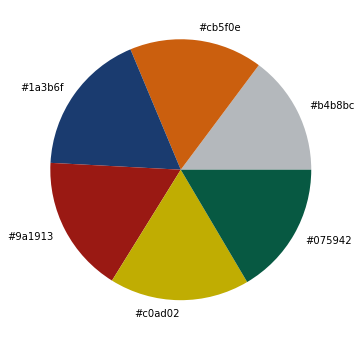

In [8]:
get_colors(get_image('images/colors.jpg'), 6, True)

In [9]:
COLORS = {
    'F': [7,100,67], #green
    'U': [180,185,189], #white
    'D': [180,156,11],#yellow
    'B' : [26,59,120],#blue
    'L':[201,92,19],#orange
    'R':[190,31,42] #red
#     'Green': [7,89,67],
#     'White': [180,185,189],
#     'Yellow': [180,156,11],
#     'Blue' : [26,59,120],
#     'Orange':[201,92,19],
#     'Red':[190,31,33]
}

# COLORS = {
#     'Green': [7,89,67],
#     'White': [180,185,189],
#     'Yellow': [193,177,2],
#     'Blue' : [26,59,112],
#     'Orange':[180,95,13],
#     'Red':[140,30,37]
# }

In [10]:
# working
def find_colors(img,color_list):
#     img = cv.imread("./images/D1.jpeg")
    original  = img.copy()
#     cv.imshow('img',img) 
    height, width, _ = original.shape
    print(f"height = {height}, width = {width}")
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # type of blur which preserves edges
    # blur = cv.bilateralFilter(gray, 7, 7,10)
    # sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    # sharpen_kernel_5 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    # sharpen_kernel_4 = np.array([[0,1,0], [1,-4,1], [0,1,0]])

    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
    # sharpen_4 = cv.filter2D(blur, -1, sharpen_kernel_4)
    # sharpen_5 = cv.filter2D(blur, -1, sharpen_kernel_5)
    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)


    # thresh = cv.adaptiveThreshold(sharpen,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,9,1)
    thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))



    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
    # thresh = cv.threshold(thresh,127,255,cv.THRESH_BINARY)

    cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
    # cnts = cv.findContours(close,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
    cnts = sorted(cnts, key=lambda x: cv.contourArea(x))


    number = 0
    min_area = 34000
    max_area = 50000
    x = y = w = h = 0
    for c in cnts:
        area = cv.contourArea(c)
        if area > min_area and area < max_area:
            print(area)
            x,y,w,h = cv.boundingRect(c)
    #         print(x,y,w,h,end=" ")
            tmp = original[y:y+h, x:x+w]
    #         cv.imshow("{}".format(number + 1),tmp)
    #         sq_color = identify_color(tmp)
#             cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
            cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
    #         original[y:y+h,x:x+w] = [255,255,255]
    #         original = cv.circle(original,((x+x+w)//2 , (y+y+h)//2),radius=1, color=(255, 255, 255), thickness=-1)
            number += 1
#             cv.imwrite(f"new_{random.randint(0,100)}.jpeg",tmp)
    #         cv.putText(original, "#{}".formatnumber), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            break

    # cv.imshow('tmp',tmp)
    # print("dims = ",x,y,w,h,end=" ")
    colors = []
    for i in range(1,4):
        for j in range(1,4):
            sq = original[y + (i-1)* (h//3):y+(i)* (h//3),x+(j-1)*(w//3):x+(j)*(w//3)]
    #         cv.rectangle(original,(x+(j-1)*(w//3),y + (i-1)* (h//3)),(x+(j)*(w//3),y+(i)* (h//3)),(36,255,12), 2)
#             original = cv.circle(original, ((x+(j-1)*(w//3) + x+(j)*(w//3))//2 ,(y + (i-1)* (h//3) + y+(i)* (h//3))//2), radius=10, color=(0, 0, 255), thickness=-1)
            color = identify_color(sq,color_list)
            colors.append(color)
#             cv.putText(original, "#{}".format(color), (x+(j-1)*(w//3),y + (i-1)* (h//3) - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            
    #         cv.imshow(f'square ({i},{j})',sq)\
    colors = ''.join(colors)
    # colors = str(colors)
#     print(colors)
#     cv.imshow('thresh',thresh)
#     resized_thresh = cv.resize(thresh, (300,600), interpolation= cv.INTER_LINEAR)
#     cv.imshow('resized_thresh',resized_thresh)
    # cv.imshow('sharpen_4',sharpen_4)
    # cv.imshow('sharpen_5',sharpen_5)
    # cv.imshow('blur', blur)
    # cv.imshow('gray',gray)
    # cv.imshow('original', original)
#     resized_down = cv.resize(original, (400,400), interpolation= cv.INTER_LINEAR)
#     cv.imshow('resized',resized_down)

    # cv.imshow('sharpen',sharpen)
#     cv.waitKey()
#     cv.destroyWindow('resized')
    return colors

In [11]:
import sys
front_face=right_face=back_face=left_face=up_face=down_face = ""

In [12]:
def display_instructions(video,text=""):
    isTure,img = video.read()
#     cv.imshow(text,img)
    if not isTrue:
        print("Cannot read video source")
        return
    cv.putText(img, text, (25,75), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2, cv.LINE_AA)
    cv.imshow(text,img)
#     cv.waitKey()
#     cv.destroyAllWindows()
    

In [13]:
def detect_face_of_cube(video,COLORS,face_no,text=""):
    while True:
        isTrue,img = video.read()
        cv.imshow(text,img)
        if not isTrue:
            print("Cannot read video source")
            return
        try:
            display_instructions(video,text)
            global front_face
            global right_face
            global left_face
            global back_face
            global up_face
            global down_face

            if face_no == 1:
                front_face = find_colors(img,COLORS)
            elif face_no == 2:
                right_face = find_colors(img,COLORS)
            elif face_no == 3:
                back_face = find_colors(img,COLORS)
            elif face_no == 4:
                left_face = find_colors(img,COLORS)
            elif face_no == 5:
                up_face = find_colors(img,COLORS)
            elif face_no == 6:
                down_face = find_colors(img,COLORS)
            face_no += 1
            cv.destroyWindow(text)
        except:
            pass
        return face_no

In [14]:
video = cv.VideoCapture(2)
isTrue, img = video.read()
broke = 0
h1 = img.shape[0]
w1 = img.shape[1]

print(f"h = {h1},w = {w1}")
instructions = {
    1 : "Show Front Face (Green in center)",
    2 : "Show Face to the Right (Turn Right)",
    3 : "Show Face just Behind (Turn Right)",
    4 : "Show Face to the Left (Turn Right)",
    5 : "Show Face just Above (Turn Right and Up)",
    6 : "Show Face just Below (Turn Down 2 times)",
    7 : "Show Front Face (Turn Up)"
}

if not isTrue:
    print("Cannot read video source")
    sys.exit()
face_no = 1
while True:
    isTrue,img = video.read()
    if not isTrue:
        break
    x = w1//2 - 4*h1//16
    y = h1//3
    w = 4*h1//10
    h = 4*h1//10
#     cv.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)
#     cv.imshow(instructions[face_no],img)
    if (face_no < 8):
#         cv.imshow(instructions[face_no],img)
        display_instructions(video,instructions[face_no])
        cv.moveWindow(instructions[face_no], 100,100)
    if cv.waitKey(1) == ord('c') and face_no<7: # extracting color from cube after click 'c' on keyboard
        print("Extraction colors")
        face_no = detect_face_of_cube(video,COLORS,face_no,instructions[face_no])

#     if cv.waitKey(1) == ord('s'): # start kociema module     
#         kociema(color)
    if cv.waitKey(1) == ord('q'):
        break
video.release()
cv.destroyAllWindows()

h = 480,w = 640
Extraction colors
height = 480, width = 640
Extraction colors
height = 480, width = 640
48566.5
{36: 'L', 43: 'D', 46: 'R', 52: 'U'}
{23: 'U', 36: 'F', 53: 'D'}
{9: 'F', 55: 'U'}
{9: 'F', 55: 'U'}
{11: 'F', 57: 'U'}
{10: 'F', 56: 'U'}
{19: 'D', 49: 'F', 51: 'L', 59: 'U'}
{9: 'F', 55: 'U'}
{8: 'F', 55: 'U'}
Extraction colors
height = 480, width = 640
Extraction colors
height = 480, width = 640
49845.5
{41: 'R', 44: 'L', 54: 'U', 57: 'F'}
{38: 'R', 44: 'L'}
{40: 'R', 45: 'L', 56: 'U', 59: 'F'}
{37: 'R', 43: 'L', 58: 'U'}
{34: 'R', 43: 'L'}
{35: 'R', 43: 'L'}
{40: 'R', 44: 'L', 54: 'U', 58: 'F', 59: 'B'}
{36: 'R', 44: 'L'}
{37: 'R', 43: 'L', 59: 'U'}
Extraction colors
height = 480, width = 640
Extraction colors
height = 480, width = 640
Extraction colors
height = 480, width = 640
Extraction colors
height = 480, width = 640
Extraction colors
height = 480, width = 640
Extraction colors
height = 480, width = 640
Extraction colors
height = 480, width = 640


In [15]:
def concat_final(front_face,right_face,back_face,left_face,up_face,down_face):
    final_str = ""
    final_str = final_str + up_face
    final_str = final_str + right_face
    final_str = final_str + front_face  
    final_str = final_str + down_face 
    final_str = final_str + left_face
    final_str = final_str + back_face 
    print(final_str)
    return final_str

In [16]:
# print(f"front face is {front_face}")
# print(f"right face is {right_face}")
# print(f"back face is {back_face}")
# print(f"left face is {left_face}")
# print(f"up face is {up_face}")
# print(f"down face is {down_face}")
# final_str = concat_final(front_face,right_face,back_face,left_face,up_face,down_face)
# # print(back_str)
# print(final_str)
# # # down = 
try:
    steps_to_follow = kociemba.solve(final_str)
except:
    print("some error occured")
    sys.exit()
    
# steps_to_follow

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



some error occured
Traceback (most recent call last):
  File "<ipython-input-16-b26cbbea3f9c>", line 12, in <module>
    steps_to_follow = kociemba.solve(final_str)
NameError: name 'final_str' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b26cbbea3f9c>", line 15, in <module>
    sys.exit()
SystemExit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "D:\Anaconda\lib\site-packages\IPython\core\ultratb.py", line 248, in wrapped
    return f(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\IPython\core\ultratb.py

TypeError: object of type 'NoneType' has no len()

In [17]:
from datetime import datetime,timedelta

In [18]:
def time_to_seconds(time):
    time_lst = time.split(":")
    seconds = 0
    seconds = int(time_lst[0])*60*60 + int(time_lst[1])*60 + int(time_lst[2])
    return seconds

def time_taken(start_time,end_time):
    sec = time_to_seconds(end_time) - time_to_seconds(start_time)
    return sec

In [19]:
def return_points(x,y,w,h):
    point_lst = []
    for i in range(1,4):
        for j in range(1,4):
            point_lst.append((x + (2*j-1)*w//6,y + (2*i-1)*h//6))
#     print(point_lst)
    return point_lst

In [20]:
def r_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[2], points_lst[8], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[2], points_lst[8], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [21]:
def l_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[0], points_lst[6], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[0], points_lst[6], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [22]:
def l_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[6], points_lst[0], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[6], points_lst[0], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [23]:
def f_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img, points_lst[3], points_lst[1], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[3], points_lst[1], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[1], points_lst[5], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[1], points_lst[5], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[5], points_lst[7], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[5], points_lst[7], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[7], points_lst[3], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[7], points_lst[3], (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break
            

In [24]:
def f_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img,points_lst[1], points_lst[3],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,  points_lst[1],points_lst[3], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[5], points_lst[1], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[5], points_lst[1], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[7], points_lst[5], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[7], points_lst[5], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[3], points_lst[7], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[3], points_lst[7], (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break
            

In [25]:
def u_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[2], points_lst[0], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[2], points_lst[0], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [26]:
def u_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[0], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[0], points_lst[2], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [27]:
def d_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[6], points_lst[8], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[6], points_lst[8], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [28]:
def d_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[8], points_lst[6], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[8], points_lst[6], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [29]:
def turn_left(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img, points_lst[0], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[0], points_lst[2], (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img, points_lst[3], points_lst[5], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[3], points_lst[5], (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img, points_lst[6], points_lst[8], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[6], points_lst[8], (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [30]:
def turn_right(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img,points_lst[2], points_lst[0],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,points_lst[2], points_lst[0],  (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img,points_lst[5], points_lst[3],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,points_lst[5], points_lst[3],  (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img,points_lst[8], points_lst[6],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,points_lst[8], points_lst[6],  (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [31]:
def r_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[8], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[8], points_lst[2], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
#         else:
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [32]:
def display_solved(video):
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        cv.putText(img, "Solved!", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [33]:
# # steps = steps_to_follow.split()
video = cv.VideoCapture(2)
isTrue, img = video.read()
if not isTrue:
    sys.exit()
step = 1
r_clk(video,step)
step+=1
r_anticlk(video,step)
step+=1
l_clk(video,step)
step+=1
l_anticlk(video,step)
step+=1
f_anticlk(video,step)
step+=1
f_clk(video,step)
step+=1
u_clk(video,step)
step+=1
u_anticlk(video,step)
step+=1
d_clk(video,step)
step+=1
d_anticlk(video,step)
step+=1
turn_right(video,step)
step+=1
turn_left(video,step)
step+=1
display_solved(video)
video.release()
cv.destroyAllWindows()


36024.5
36200.5
36200.5
36178.0
36178.0
36317.5
36068.5
36068.5
36068.5
35919.5
35815.5
35815.5
35973.0
36068.0
36248.5
36248.5
36392.5
37040.5
37040.5
37261.5
37480.5
37591.5
37591.5
37370.5
37200.5
37200.5
37092.5
36978.5
36936.0
36936.0
36883.5
36681.5
36681.5
36673.5
36572.0
36572.0
36572.0
36519.5
36514.0
36514.0
36301.5
36282.5
36224.0
36224.0
36227.5
36282.0
36282.0
36215.0
36218.5
36347.5
36347.5
36306.5
36397.0
36397.0
36406.5
36366.5
36311.5
36311.5
36311.5
36299.0
36299.0
36424.5
36392.0
36371.0
36371.0
36386.0
36386.0
36386.0
36135.5
36035.5
35838.5
35838.5
35841.5
35728.0
35728.0
35629.5
35825.0
35834.5
35834.5
35798.0
35742.0
35742.0
35619.5
35388.0
34953.5
34953.5
34953.5
34858.0
34858.0
34338.5
35614.5
35614.5
35614.5
41548.5
41548.5
38694.0
34649.5
34649.5
34649.5
34600.5
34600.5
35769.5
36335.0
36335.0
35276.0
39741.0
39741.0
49834.5
49834.5
47423.5
47423.5
47423.5
35401.0
40644.0
40644.0
40063.5
49231.5
49231.5
45755.5
34080.0
34080.0
44727.5
44727.5
49373.0
49373.0


In [ ]:

video = cv.VideoCapture(2)
isTrue, img = video.read()
step_lst = steps_to_follow.split(" ")
step = 0
for move in step_lst:
    step = step + 1
    if move == "R":
        r_clk(video,step)
    elif move == "R'":
        r_anticlk(video,step)
    elif move == "R2":
        r_clk(video,step)
        step = step + 1
        r_clk(video,step)
    elif move == "L":
        l_clk(video,step)
    elif move == "L'":
        l_anticlk(video,step)
    elif move == "L2":
        l_clk(video,step)
        step = step + 1
        l_clk(video,step)
    elif move == "F":
        f_clk(video,step)
    elif move == "F'":
        f_anticlk(video,step)
    elif move == "F2":
        f_clk(video,step)
        step = step + 1
        f_clk(video,step)
    elif move == "B":
        turn_right(video,step)
        step = step + 1
        r_clk(video,step)
        step = step + 1
        turn_left(video,step)
    elif move == "B'":
        turn_right(video,step)
        step = step + 1
        r_anticlk(video,step)
        step = step + 1
        turn_left(video,step)
    elif move == "B2":
        turn_right(video,step)
        step = step + 1
        r_clk(video,step)
        step = step + 1
        r_clk(video,step)
        step = step + 1
        turn_left(video,step)
    elif move == "U":
        u_clk(video,step)
    elif move == "U'":
        u_anticlk(video,step)
    elif move == "U2":
        u_clk(video,step)
        step = step + 1
        u_clk(video,step)
    elif move == "D":
        d_clk(video,step)
    elif move == "D'":
        d_anticlk(video,step)
    elif move == "D2":
        d_clk(video,step)
        step = step + 1
        d_clk(video,step)
    else:
        pass
display_solved(video)
video.release()
cv.destroyAllWindows()
    